In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## MNIST Dataset & Dataloader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()  # scales to [0,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)


## VAE Model (Encoder + Reparameterization + Decoder)

In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()

        # -------- Encoder --------
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),   # 28 → 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 14 → 7
            nn.ReLU(),
        )

        self.flatten_dim = 64 * 7 * 7

        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # -------- Decoder --------
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 7 → 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),    # 14 → 28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.flatten_dim)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 64, 7, 7)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar


## VAE Loss: Reconstruction + KL Divergence

In [8]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss


## Training Loop

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=128).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        optimizer.zero_grad()

        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch [1/50] Loss: 163.4309
Epoch [2/50] Loss: 116.7066
Epoch [3/50] Loss: 110.8674
Epoch [4/50] Loss: 108.6190
Epoch [5/50] Loss: 107.2838
Epoch [6/50] Loss: 106.3173
Epoch [7/50] Loss: 105.6892
Epoch [8/50] Loss: 105.1985
Epoch [9/50] Loss: 104.7962
Epoch [10/50] Loss: 104.3803
Epoch [11/50] Loss: 104.0747
Epoch [12/50] Loss: 103.8225
Epoch [13/50] Loss: 103.5539
Epoch [14/50] Loss: 103.3505
Epoch [15/50] Loss: 103.1360
Epoch [16/50] Loss: 102.9058
Epoch [17/50] Loss: 102.7134
Epoch [18/50] Loss: 102.5876
Epoch [19/50] Loss: 102.4189
Epoch [20/50] Loss: 102.2791
Epoch [21/50] Loss: 102.1122
Epoch [22/50] Loss: 102.0002
Epoch [23/50] Loss: 101.8636
Epoch [24/50] Loss: 101.7486
Epoch [25/50] Loss: 101.6432
Epoch [26/50] Loss: 101.5231
Epoch [27/50] Loss: 101.4490
Epoch [28/50] Loss: 101.3115
Epoch [29/50] Loss: 101.2888
Epoch [30/50] Loss: 101.1494
Epoch [31/50] Loss: 101.0652
Epoch [32/50] Loss: 100.9878
Epoch [33/50] Loss: 100.8910
Epoch [34/50] Loss: 100.7895
Epoch [35/50] Loss: 100

## Reconstruction and latent space visualization

In [11]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, test_loader, device, num_images=8):
    model.eval()
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)

    with torch.no_grad():
        recon, _, _ = model(imgs)

    imgs = imgs.cpu()
    recon = recon.cpu()

    plt.figure(figsize=(16, 4))
    for i in range(num_images):
        # Original
        plt.subplot(2, num_images, i+1)
        plt.imshow(imgs[i].squeeze(), cmap='gray')
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, num_images, i+1+num_images)
        plt.imshow(recon[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()


## Sampling Random z to Generate Images

In [12]:
def sample_random_images(model, device, latent_dim=128, num_samples=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z).cpu()

    plt.figure(figsize=(6,6))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(samples[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()


## Interpolate Between Two Latent Vectors

In [13]:
def interpolate_latents(model, device, latent_dim=128, steps=8):
    model.eval()
    z1 = torch.randn(1, latent_dim).to(device)
    z2 = torch.randn(1, latent_dim).to(device)
    alphas = torch.linspace(0, 1, steps)

    interpolated = []
    with torch.no_grad():
        for alpha in alphas:
            z = (1 - alpha) * z1 + alpha * z2
            img = model.decode(z).cpu()
            interpolated.append(img)

    interpolated = torch.cat(interpolated, dim=0)
    plt.figure(figsize=(16,2))
    for i in range(steps):
        plt.subplot(1, steps, i+1)
        plt.imshow(interpolated[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()


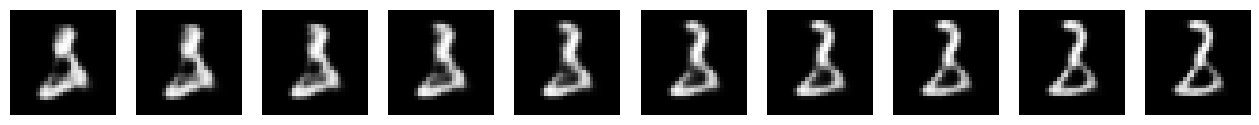

In [14]:
interpolate_latents(model, device, latent_dim=128, steps=10)


Change Latent Dimension to 256 and Retrain

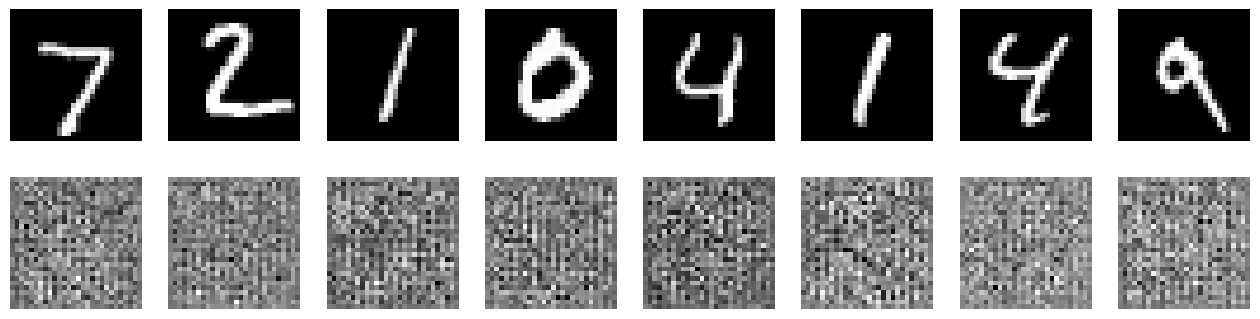

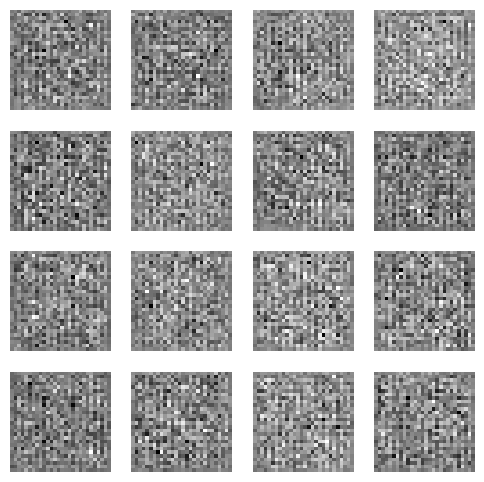

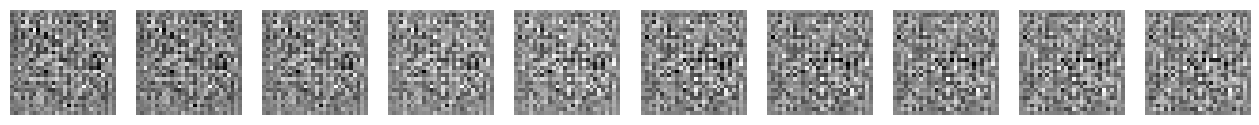

In [15]:
latent_dim = 256
model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Same training loop as before, e.g., 50 epochs
# After training, use the same visualization functions:

visualize_reconstruction(model, test_loader, device)
sample_random_images(model, device, latent_dim=latent_dim)
interpolate_latents(model, device, latent_dim=latent_dim, steps=10)


The original MNIST images show its digits clearly visible: 7, 2, 1, 0, 4, 1, 4, 9

The reconstructed images from the VAE using the latent representation showed entirely noise, meaning the model did not learn to reconstruct.

This usually happens when:

1. Latent dimension is too small for the network architecture (though 128 usually works)

2. Model is undertrained (few epochs)

3. Decoder output size mismatch (producing incorrect shapes)

4. Wrong activation (Sigmoid missing or input/output not normalized)

5. Loss function mismatch (BCE expects [0,1])

Sampled images from latent space (z ~ N(0,1)) showed random noise, indicating the VAE’s decoder is not generating meaningful digits yet.

The Bottom row could have interpolation results or additional samples from latent space.

Again, they look like noise, confirming the VAE did not converge.

The VAE is structurally correct, but the model did not learn meaningful representations yet.

The top row shows what should be reconstructed/generated.

The noisy reconstructions and random samples indicate issues in training, latent space mapping, or architecture.